<a href="https://colab.research.google.com/github/simbol105/Machine-learing-assignment/blob/main/Copy_of_10_assignment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import itertools
import numpy as np

from functools import partial
from scipy.optimize import minimize

import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder, OneHotEncoder
from sklearn.svm import SVC
from sklearn.gaussian_process import GaussianProcessRegressor
from scipy.stats import norm
from sklearn import datasets
from sklearn.metrics import accuracy_score, classification_report

# Preparing the Dataset:

In [ ]:
seed = 42
np.random.seed(seed=seed)

In [ ]:
# Load the Breast Cancer dataset
data = datasets.load_breast_cancer()
X, y = data.data, data.target

# Step 1: Split into train (60%) and temporary (40%)
X_train, X_temp, y_train, y_temp = train_test_split(
    X, y, test_size=0.4, random_state=seed, stratify=y
)

# Step 2: Split the temporary set into validation (20%) and test (20%)
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.5, random_state=seed, stratify=y_temp
)

# Preprocessing: Standardize features using the training set
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)  # Fit and transform the training set
X_val = scaler.transform(X_val)  # Transform the validation set
X_test = scaler.transform(X_test)  # Transform the test set

# Train the SVM Model

In [ ]:
# TODO START
'''
1. Initialize the SVM Classifier.
2. Fit the classifier on the training set
3. Predict on the validation dataset
'''
svm = SVC()
svm.fit(X_train, y_train)
y_pred = svm.predict(X_val)
accuracy_score(y_pred, y_val)

# TODO END

0.9824561403508771

# Initial surrogate Model

In [ ]:
# TODO START

'''
1. For each of the hyperparams, i.e., C and gamma, sample 5 values
2. Check the initial response from the initial values of hps and append to responses list
3. Evaluate the initial Configurations
'''
low = 0.01
high = 2.0
hp_configurations = np.array(list(itertools.product(np.linspace(low, high, 5), repeat=2)))



'''
1- For each hyperparameter configuration (C, gamma), train an SVM model on the training data.
2- Predict the validation set labels using the trained model.
3- Calculate the accuracy score for the predictions.
'''
responses = []

#

for hp in hp_configurations:
    svm = SVC(C=hp[0], gamma=hp[1])
    svm.fit(X_train, y_train)
    y_pred = svm.predict(X_val)
    responses.append(accuracy_score(y_pred, y_val))

'''
1. Initialize a gaussian process regressor
2. Fit your initial response to this regressor
'''
responses = np.array(responses)
surrogate = GaussianProcessRegressor()
surrogate.fit(hp_configurations, responses.reshape(-1, 1) )

# TODO END

GaussianProcessRegressor()

In [ ]:
# Inital Surrogate response for plotting
# Combinations of different hyperparameter values for the surrogate plotting
hyperparameter_values = np.array(list(itertools.product(np.linspace(low, high, 100), repeat=2)))
initial_surrogate_response = surrogate.predict(hyperparameter_values)

# Aquisition functions

In [ ]:
def LCB(hp_value, surrogate_model, eta=0, add=None):
    """
    Upper Confidence Bound
    :param hp_value: point to determine the acquisition value
    :param surrogate_model: GP to predict target function value
    :param add: additional parameters necessary for the function
    """
    hp_value = hp_value.reshape(-1, 2)
    # TODO START
    '''
    1. Use GP to predict the mean and variance
    2. Make every value that are 0 in variance to 1e-9 for numerical stability
    3. Perform the LCB to get acquisition value
    '''
    ...
    acquisition_value = GaussianProcessRegressor.predict(surrogate_model, hp_value)

    # TODO END
    return acquisition_value.ravel()

In [ ]:
def UCB(hp_value, surrogate_model, eta=0, add=None):
    """
    Upper Confidence Bound
    :param hp_value: point to determine the acquisition value
    :param surrogate_model: GP to predict target function value
    :param add: additional parameters necessary for the function
    """
    hp_value = hp_value.reshape(-1, 2)
    # TODO START
    '''
    1. Use GP to predict the mean and variance
    2. Make every value that are 0 in variance to 1e-9 for numerical stability
    3. Perform the UCB to get acquisition value
    '''
    ...
    acquisition_value =  GaussianProcessRegressor.predict(surrogate_model, hp_value)

    # TODO END
    return -1 * acquisition_value.ravel()

In [ ]:
def EI(hp_value, surrogate_model, eta=0, add=None):
    """
    Expected Improvement
    :param hp_value: point to determine the acquisition value
    :param surrogate_model: GP to predict target function value
    :param eta: The best response seen so far (incumbent)
    :param add: additional parameters necessary for the function
    """
    hp_value = hp_value.reshape(-1, 2)

    # TODO (BONUS) START
    m, s = surrogate_model.predict(hp_value, return_std=True)
    s[s == 0] = 1e-9
    d = norm(loc=0, scale=1)
    delta = eta - m
    ei = delta * d.cdf(delta / s) + s * d.pdf(delta / s)
    # TODO END
    return -1 * ei.ravel()

# SMBO

In [ ]:
def run_smbo(surrogate, hp_configurations, responses, acquisition_function, max_iterations=50):

  for _ in range(max_iterations):

      search_values = np.array(list(itertools.product(np.linspace(low, high, 1000), repeat=2)))

      # Apply the acquisition function
      acq_values = acquisition_function(search_values, surrogate)

      #  Train the SVM with the new hyperparameter configuration
      c, gamma = acq_values.argmax() // 5, acq_values.argmax() % 5


      # Update the surrogate model dataset
      responses = np.append(responses, accuracy_score(y_pred, y_val))
      hp_configurations = np.append(hp_configurations, np.array([[c, gamma]]), axis=0)

      # Refit the surrogate model with the updated dataset.
      surrogate.fit(hp_configurations, responses.reshape(-1, 1))



  final_surrogate_response = surrogate.predict(hyperparameter_values)
  return hp_configurations, responses, final_surrogate_response

In [ ]:
hp_configurations, responses, final_surrogate_response = run_smbo(surrogate, hp_configurations, responses, acquisition_function = EI, max_iterations=50)

# Results

In [ ]:
final_idx = np.argmax(responses)
print(f'Best hp configuration: {hp_configurations[final_idx]} with performance: {responses[final_idx]}')

Best hp configuration: [1.005 0.01 ] with performance: 0.9824561403508771


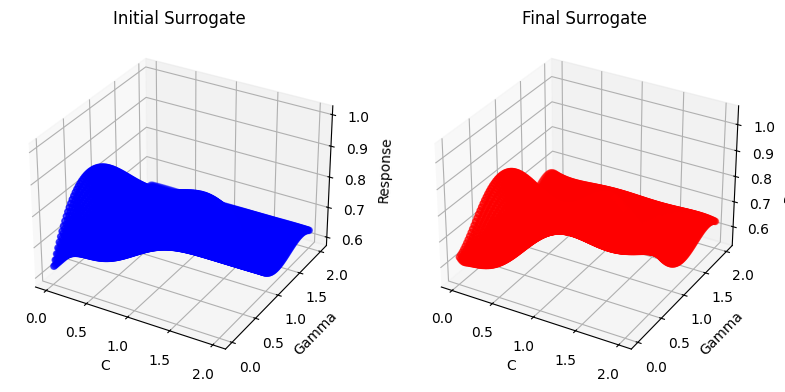

In [ ]:
# Extracting hyperparameter values into separate arrays
c_values = [hp[0] for hp in hyperparameter_values]  # Extract C values
gamma_values = [hp[1] for hp in hyperparameter_values]  # Extract Gamma values

# Convert lists to numpy arrays for consistency
c_values = np.asarray(c_values)
gamma_values = np.asarray(gamma_values)
initial_surrogate_response = np.asarray(initial_surrogate_response)
final_surrogate_response = np.asarray(final_surrogate_response)

# Plotting the initial and final surrogate responses
fig = plt.figure(figsize=plt.figaspect(0.5))  # Set the figure size

# First subplot: Initial Surrogate
ax1 = fig.add_subplot(1, 2, 1, projection='3d')  # Add 3D subplot
ax1.scatter(c_values, gamma_values, initial_surrogate_response, c='blue', label='Initial Response')
ax1.set_title('Initial Surrogate')  # Set the plot title
ax1.set_xlabel('C')  # Label the x-axis
ax1.set_ylabel('Gamma')  # Label the y-axis
ax1.set_zlabel('Response')  # Label the z-axis

# Second subplot: Final Surrogate
ax2 = fig.add_subplot(1, 2, 2, projection='3d')  # Add another 3D subplot
ax2.scatter(c_values, gamma_values, final_surrogate_response, c='red', label='Final Response')
ax2.set_title('Final Surrogate')  # Set the plot title
ax2.set_xlabel('C')  # Label the x-axis
ax2.set_ylabel('Gamma')  # Label the y-axis
ax2.set_zlabel('Response')  # Label the z-axis

# Show the plots
plt.show()